### Final Project

1. orientation
2. velocity

set body length to 1 unit, pool size about 1000x body size?

Notemigonus crysoleucas (golden shiner) and Gambusia holbrooki (mosquitofish)
cap the max velocity at like 50 cm/s so like 10 bodylength per seconds

visual latency is in the order of 10ms

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import random as rng
from matplotlib import colors
import matplotlib as mpl
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
import matplotlib.markers as mmarkers


Initialization

In [5]:
N = 2 #number of fish
poolsize = 30 #relative to body length, maybe 1000
maxvelocity = 10 #bodylength per seconds

#init coordinations
motcoords = [(rng.randint(0,poolsize),rng.randint(0,poolsize)) for i in np.arange(N)]
xcoords, ycoords = zip(*motcoords)

#init orientations
radmotangles = [rng.uniform(0,2*np.pi) for i in np.arange(N)]
degmotangles = np.rad2deg(radmotangles)

#initialize velocity magnitude array
motvelmag = np.zeros(N)

#create a velocity (direction & magnitude) array
motvel = [(motvelmag[i]*np.cos(radmotangles[i]),motvelmag[i]*np.sin(radmotangles[i])) for i in np.arange(N)]

Rule setting

In [6]:
#get distance to each neighbor
def finddistances(myindex, mycoord, coordarray):
    distances = [np.linalg.norm(np.subtract(mycoord, coordarray[i])) if i != myindex else np.nan for i in np.arange(len(coordarray))]
    return distances

#define crossproduct
def cross2d(a, b):
    return a[0] * b[1] - a[1] * b[0]

#first find and index nearest neighbor
testcoord = (0,0)
coords = [(0,0), (1,0), (2,0), (0,3), (-4,3)]

def findnearestneighbor(myindex, mycoord, coordarray):
    dist = finddistances(myindex, mycoord, coordarray)
    neighbor_index = np.nanargmin(dist)
    nearestdist = dist[np.nanargmin(dist)]
    return neighbor_index, nearestdist, dist

def findangletoneighbor(myorientation, mycoord, neighborcoord):
    correctionfornow = myorientation + np.pi/2
    myangle = correctionfornow #in radians
    myvector = (np.cos(myangle),np.sin(myangle))
    #get vector from me to you and normalize it
    vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))
    #calculate the dot product and the cross product
    dotproduct = np.dot(myvector, vector_from_me_to_you) 
    crossproduct = cross2d(myvector, vector_from_me_to_you)
    return dotproduct, crossproduct

findnearestneighbor(0, testcoord, coords)

(np.int64(1),
 np.float64(1.0),
 [nan, np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(5.0)])

Test

[(18, 9), (14, 5)]
[4.976807280158812, 6.180840836631222]
(np.float64(nan), np.float64(nan))
(np.float64(-0.8673318883725726), np.float64(-0.49773024361803386))


/var/folders/l9/3b20jgkd5w1dxc04tf2j0vgc0000gn/T/ipykernel_47835/1706004901.py:25: RuntimeWarning: invalid value encountered in divide
  vector_from_me_to_you = np.subtract(neighborcoord,mycoord)/np.linalg.norm(np.subtract(neighborcoord,mycoord))


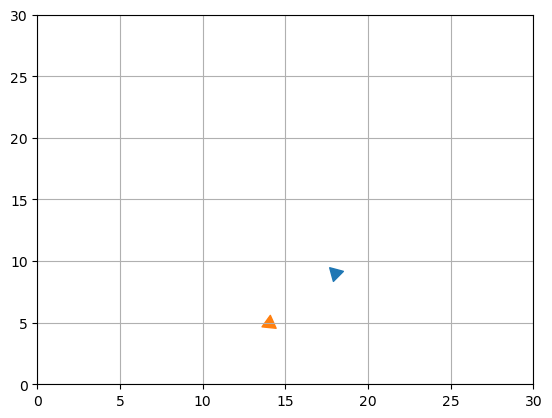

In [7]:
#test
fig, ax = plt.subplots()
#scaling follows s = 125000/x^2 where x is the width of the coordinate

for i in np.arange(N):
    ax.scatter(xcoords[i],ycoords[i], marker = (3,0, degmotangles[i]), s = 125000/poolsize**2)

ax.set_xlim(0,poolsize)
ax.set_ylim(0,poolsize)
ax.grid()
plt.plot()


print(motcoords)
print(radmotangles)

for i in np.arange(N):
    print(findangletoneighbor(radmotangles[0], motcoords[0], motcoords[i]))


In [8]:
#movement setting
#1. update acceleration (new velocity magnitude)
#2. update orientation
#3. update coordinate based on new velocity 
t = 0.01 #timestep doesn't have to be 1, since fish think faster than they move maybe this should be lower like 10-100 milliseconds
motcoords = [np.add(motcoords[i],np.array(motvel[i])*t) for i in np.arange(N)] # x = x+vt for all fish

- Radius of 1 body length = R 
- Speed: (front-back over side-side): This acceleration response was dependent on the fish’s current speed (multiply velocity by a factor)
- Attractive over R => accelerates/decelerates according to front or back
    - accelerate 1 bodylength based on the function cos(theta) where theta is the angle between the fish and its neighbor?
- Maybe some weight over front than back
- Repulsive inside R => accelerates/decelerates according to front or back
- Turn: (relative angle over distance)
- Turn towards neighbor’s position (30-60º rotation depending on relative angle)


In [9]:
#run this for all fish in one timestep
#we can also change the fish to only respond to a certain angle of neighbor, like -pi/3 to pi/3 rad
#error about 0.25 maybe, can change

def updatefish(positions,speeds,radorientations,timestep = 0.1, maxa = 0.5, maxdwdt = 0.5, erroracc = 0, errordwdt = 0):
    t = timestep
    maxspeed = 10
    for i in np.arange(len(positions)):
        #first find the nearest neighbor
        neighindex, neighdist, dist = findnearestneighbor(i, positions[i], positions)
        #find its dotproduct
        dotproduct, crossproduct = findangletoneighbor(radorientations[i],positions[i],positions[neighindex]) #simply cos(theta)
        #calculate the acceleration based on the dotproduct
        motacc = maxa*dotproduct + rng.uniform(-erroracc,erroracc)
        #Speed rule 1, attractve over R (2 body lengths) 
        if neighdist > 2:
            #update velocity magnitude based on where the other fish is. If in front, accelerate, if behind, deccelerate by a constant, let's say 0.5 bl/s^2. also fish only respond to the  60º in front
            if np.abs(speeds[i] + motacc*t) <= maxspeed:
                speeds[i] = speeds[i] + motacc*t 
            else:
                speeds[i] = speeds[i]
        #speed rule 2, repulsive under R
        elif neighdist < 2:
            #if behind, accelerate forward. if ahead, decelerate
            if np.abs(speeds[i] - motacc*t) <= maxspeed:
                speeds[i] = speeds[i] - motacc*t 
            else:
                speeds[i] = speeds[i]
        #orientation rule 1, turn towards nearest neighbor
        dwdt = maxdwdt*crossproduct + rng.uniform(-errordwdt,errordwdt) #radpersecond
        radorientations[i] = radorientations[i] + dwdt*t
    return speeds, radorientations

fishpos = [(0,0), (5,5)]
spd = [0,0]
radfish = [0, 0]

print(updatefish(fishpos, spd, radfish))
        

([np.float64(0.035355339059327376), np.float64(-0.035355339059327376)], [np.float64(-0.035355339059327376), np.float64(0.035355339059327376)])


[]

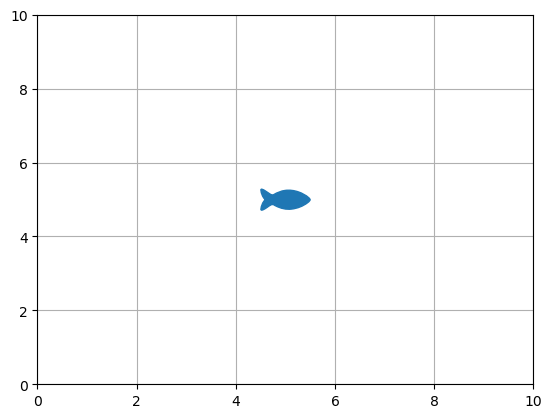

In [79]:
fih_path, attributes = svg2paths('fih.svg')
fmarker = parse_path(attributes[0]['d'])
fmarker.vertices -= fmarker.vertices.mean(axis=0)
fmarker = fmarker.transformed(mpl.transforms.Affine2D().scale(1,-1))
fmarker = fmarker.transformed(mpl.transforms.Affine2D().rotate_deg(0))

#linear scaling with respect to max x and y coord
coo = 10
plt.plot(coo/2-0.06,coo/2, marker = fmarker, markersize = 400/coo)

plt.grid()
plt.xlim(0,coo)
plt.ylim(0,coo)

plt.plot()


Plot

[]

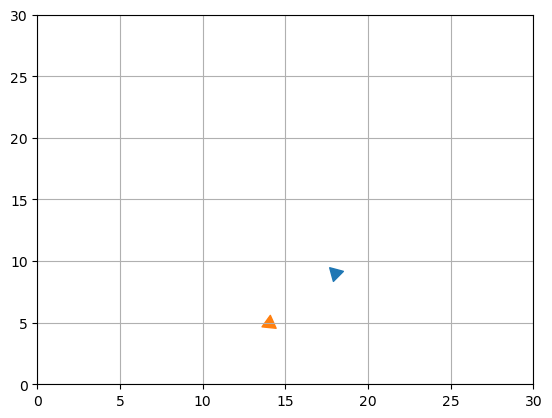

In [10]:
fig, ax = plt.subplots()
#scaling follows s = 125000/x^2 where x is the width of the coordinate

for i in np.arange(N):
    ax.scatter(xcoords[i],ycoords[i], marker = (3,0, degmotangles[i]), s = 125000/poolsize**2)

ax.set_xlim(0,poolsize)
ax.set_ylim(0,poolsize)
ax.grid()
plt.plot()


Analysis